# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<br>

In [1]:
#!pip install networkx==2.3

In [2]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph
from tqdm import tqdm

In [3]:
nx.__version__ 

'2.3'

In [4]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [5]:
edges = [tuple(x) for x in data.values.tolist()]

In [6]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [7]:
A = list(nx.connected_component_subgraphs(B))[0]

In [8]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


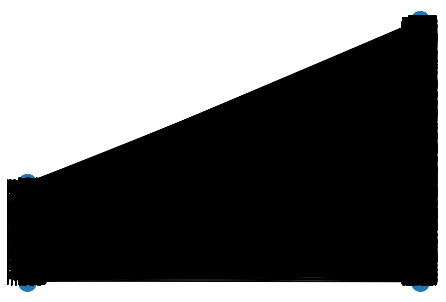

In [9]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [10]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [11]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [12]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [13]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [14]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

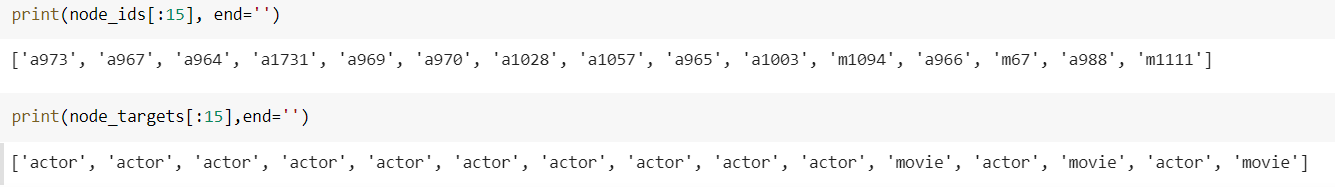

In [15]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
    node_targets1 = np.array([node_targets])
    indexes_actors = np.where(node_targets1 == 'actor')[1] 
    indexes_movies = np.where(node_targets1 == 'movie')[1]
    for i in indexes_actors:
        actor_nodes.append(node_ids[i])
        actor_embeddings.append(node_embeddings[i])
    
    for j in indexes_movies:
        movie_nodes.append(node_ids[j])
        movie_embeddings.append(node_embeddings[j])
    
    
    
    

    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings
  


In [16]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings=data_split(node_ids,node_targets,node_embeddings)

<font color='cyan'>Graded function - 1</font>

In [17]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Graded function - 2</font>

In [18]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [19]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    N = number_of_clusters
    larest_cc = max(nx.connected_components(graph), key = len)
    num_nodes_L_cc = len(larest_cc)
    total_num_nodes = graph.number_of_nodes()
   
    cost1= num_nodes_L_cc/total_num_nodes
    cost1 = cost1/N
    return cost1

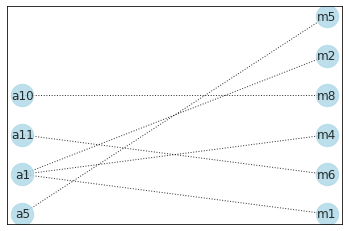

In [20]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Graded function - 3</font>

In [21]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [22]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    N = number_of_clusters
    Sum_degree = graph.number_of_edges()
    movies = []
    for i in graph.nodes():
        if 'm' in i:
           movies.append(i)
    movies = set(movies)
    L_movies = len(movies)
    cost2= Sum_degree/L_movies
    cost2 = cost2/N
    
    return cost2

<font color='cyan'>Graded function - 4</font>

In [23]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

In [24]:
def subgraph_s(each_clusters_nodes):
        
        '''In this function, we will return subgraphs of a given graph based on the no-of clusters'''
        subgraph = nx.Graph()
        ego_graphs = []

        for j in range(len(each_clusters_nodes)):
                    cluster = each_clusters_nodes[j]
                    subgraph = nx.Graph()
                    for node_i in cluster:
                        cluster_graph=nx.ego_graph(B,node_i,radius=3)
                        subgraph.add_nodes_from(cluster_graph.nodes())
                        subgraph.add_edges_from(cluster_graph.edges())
                    ego_graphs.append(subgraph)
        return ego_graphs

# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

In [25]:

from sklearn.cluster import KMeans
def ClusterIndices(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]


number_of_clusters_List = [3, 5, 10, 30, 50, 100, 200, 500]

Cost_List = []
for i in tqdm(number_of_clusters_List):
    # Fitting clustering algorithm to actor embeddings and getting nodes in each cluster
    clustering = KMeans(n_clusters=i,init = 'k-means++', random_state=0)
    clustering.fit(actor_embeddings)
    labels = clustering.labels_
    actor_nodes1 = np.array(actor_nodes)
    each_cluster_actor_nodes = []
    number_of_clusters = i
    for x in range(number_of_clusters):
        y = ClusterIndices(x,labels)
        z = actor_nodes1[y]
        each_cluster_actor_nodes.append(z)
    subgraphs = subgraph_s(each_cluster_actor_nodes)
    
    Cost1 = []
    Cost2 = []
    for j in range(number_of_clusters):
        Cost11 = cost1(subgraphs[j],number_of_clusters)
        Cost1.append(Cost11)
        Cost22 = cost2(subgraphs[j],number_of_clusters)
        Cost2.append(Cost22)
    
    Cost = (sum(Cost1)) * (sum(Cost2))
    Cost_List.append(Cost)
    

100%|██████████| 8/8 [04:43<00:00, 35.43s/it]


In [26]:
for x in range(len(Cost_List)):
    print("For k = {} , Cost = {}".format(number_of_clusters_List[x] ,Cost_List[x] ))

For k = 3 , Cost = 6.824165057918872
For k = 5 , Cost = 5.910486151327374
For k = 10 , Cost = 4.952555683185622
For k = 30 , Cost = 3.8528247493859515
For k = 50 , Cost = 3.2996076972985584
For k = 100 , Cost = 3.0680117862526064
For k = 200 , Cost = 2.6291596039391187
For k = 500 , Cost = 1.9767068723860768


<h4>The Best value of k is 3. Since we got maximum cost if no-of clusters = 3</h4>

<font color='blue'>Grouping similar actors</font>

In [27]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)
y_kmeans = kmeans.fit_predict(actor_embeddings)

<font color='blue'>Displaying similar actor clusters in 2-D</font>

In [28]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
Actor_node_embeddings_2d = trans.fit_transform(actor_embeddings)
X = Actor_node_embeddings_2d

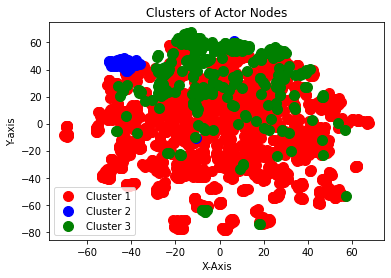

In [29]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.title('Clusters of Actor Nodes')
plt.xlabel('X-Axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

# <font color='red'>Task 2 : Apply clustering algorithm to group similar Movies</font>

In [30]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    N = number_of_clusters
    larest_cc = max(nx.connected_components(graph), key = len)
    num_nodes_L_cc = len(larest_cc)
    total_num_nodes = graph.number_of_nodes()
   
    cost1= num_nodes_L_cc/total_num_nodes
    cost1 = cost1/N
    return cost1

In [31]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    N = number_of_clusters
    Sum_degree = graph.number_of_edges()
    actors = []
    for i in graph.nodes():
        if 'a' in i:
           actors.append(i)
    actors = set(actors)
    L_actors = len(actors)
    cost2= Sum_degree/L_actors
    cost2 = cost2/N
    
    return cost2

In [32]:

from sklearn.cluster import KMeans
def ClusterIndices(clustNum, labels_array): # This function will return the indices of nodes belongs to puticular cluster
    return np.where(labels_array == clustNum)[0]


number_of_clusters_List = [3, 5, 10, 30, 50, 100, 200, 500]

Cost_List = []
for i in tqdm(number_of_clusters_List):
    # Fitting clustering algorithm to actor embeddings and getting nodes in each cluster
    clustering = KMeans(n_clusters=i,init = 'k-means++', random_state=0)
    clustering.fit(movie_embeddings)
    labels = clustering.labels_
    movie_nodes1 = np.array(movie_nodes)
    each_cluster_movie_nodes = []
    number_of_clusters = i
    for x in range(number_of_clusters):
        y = ClusterIndices(x,labels)
        z = movie_nodes1[y]
        each_cluster_movie_nodes.append(z)
    subgraphs = subgraph_s(each_cluster_movie_nodes)
    
    Cost1 = []
    Cost2 = []
    for j in range(number_of_clusters):
        Cost11 = cost1(subgraphs[j],number_of_clusters)
        Cost1.append(Cost11)
        Cost22 = cost2(subgraphs[j],number_of_clusters)
        Cost2.append(Cost22)
    
    Cost = (sum(Cost1)) * (sum(Cost2))
    Cost_List.append(Cost)
    

100%|██████████| 8/8 [06:32<00:00, 49.05s/it]


In [33]:
for x in range(len(Cost_List)):
    print("For k = {} , Cost = {}".format(number_of_clusters_List[x] ,Cost_List[x] ))

For k = 3 , Cost = 2.640166252345703
For k = 5 , Cost = 2.754527229878902
For k = 10 , Cost = 2.640396521493657
For k = 30 , Cost = 2.4144051475990085
For k = 50 , Cost = 2.2355453008266863
For k = 100 , Cost = 2.1746033526733406
For k = 200 , Cost = 2.159198134082829
For k = 500 , Cost = 2.395147961230284


<h4>The Best value of k is 5. Since we got maximum cost if no-of clusters = 5</h4>

<font color='blue'>Grouping similar movies</font>

In [35]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 0)
y_kmeans = kmeans.fit_predict(movie_embeddings)

<font color='blue'>Displaying similar movie clusters in 2D</font>

In [37]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
Movie_node_embeddings_2d = trans.fit_transform(movie_embeddings)
X = Movie_node_embeddings_2d

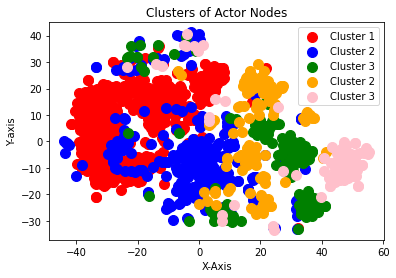

In [38]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'orange', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 100, c = 'pink', label = 'Cluster 3')
plt.title('Clusters of Actor Nodes')
plt.xlabel('X-Axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()